**Importing**

In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

import matplotlib.pyplot as plt

**Seeding**

In [2]:
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

**Hyperparameters**

In [3]:
batch_size = 8
lr = 1e-4
epochs = 100
height = 224
width = 224

**Path**

In [4]:
images_path = os.path.join("total_train_data", "Images")
masks_path = os.path.join("total_train_data", "Masks")

dataset_path = os.path.join("total_train_data")

files_dir = os.path.join("files")
model_file = os.path.join(files_dir, "model.h5")
log_file = os.path.join(files_dir, "log.csv")

**Muilding Unet**

In [5]:
# Convolution Block

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [6]:
# Encoder Block

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [7]:
# Decoder Block

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

In [8]:
# Build UNET

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

**Dataset Pipeline**

In [9]:
def load_data():
    train_x = sorted(glob(os.path.join(images_path, "*")))
    train_y = sorted(glob(os.path.join(masks_path, "*")))

    return (train_x, train_y)

In [10]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    return x

In [11]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [12]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])

    return x, y

In [13]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

**Training**

In [14]:
(train_x, train_y) = load_data()

In [15]:
assert len(train_x) == len(train_y)
print(len(train_x))

2618


In [16]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)

In [17]:
j = 1
init_x = 0
init_y = 0

for x, y in train_dataset:
    if j==1:
        init_x = x
        init_y = y
        j = j - 1
        
    print(x.shape, y.shape)

(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 

In [18]:
input_shape = (height, width, 3)
model = build_unet(input_shape)

In [19]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 64)         0         ['batch_normalization[0][0]

In [20]:
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc"])

In [21]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='loss', patience=20, restore_best_weights=False)
]

In [24]:
summary = model.fit(train_dataset, epochs=epochs, callbacks=callbacks, initial_epoch=28)

Epoch 10/100



328/328 [==============================] - 1669s 5s/step - loss: 0.1637 - acc: 0.9301 - lr: 1.0000e-04
Epoch 11/100
328/328 [==============================] - 1648s 5s/step - loss: 0.1603 - acc: 0.9312 - lr: 1.0000e-04
Epoch 12/100
328/328 [==============================] - 1656s 5s/step - loss: 0.1559 - acc: 0.9345 - lr: 1.0000e-04
Epoch 13/100
328/328 [==============================] - 1652s 5s/step - loss: 0.1534 - acc: 0.9363 - lr: 1.0000e-04
Epoch 14/100
328/328 [==============================] - 1659s 5s/step - loss: 0.1532 - acc: 0.9360 - lr: 1.0000e-04
Epoch 15/100
328/328 [==============================] - 1653s 5s/step - loss: 0.1496 - acc: 0.9381 - lr: 1.0000e-04
Epoch 16/100
328/328 [==============================] - 1659s 5s/step - loss: 0.1469 - acc: 0.9393 - lr: 1.0000e-04
Epoch 17/100
328/328 [==============================] - 1651s 5s/step - loss: 0.1463 - acc: 0.9394 - lr: 1.0000e-04
Epoch 18/100
328/328 [==============================] - 1655s 5s/step - loss: 0.1436

KeyboardInterrupt: 

In [28]:
i = 4

In [23]:
model = load_model('files/model{}.h5'.format(i))

In [29]:
model.save('model{}.h5'.format(i))

In [30]:
model.save_weights('files/model{}_weights.h5'.format(i))

In [31]:
pred = model.predict(init_x)

1/1 [==============================] - 1s 1s/step


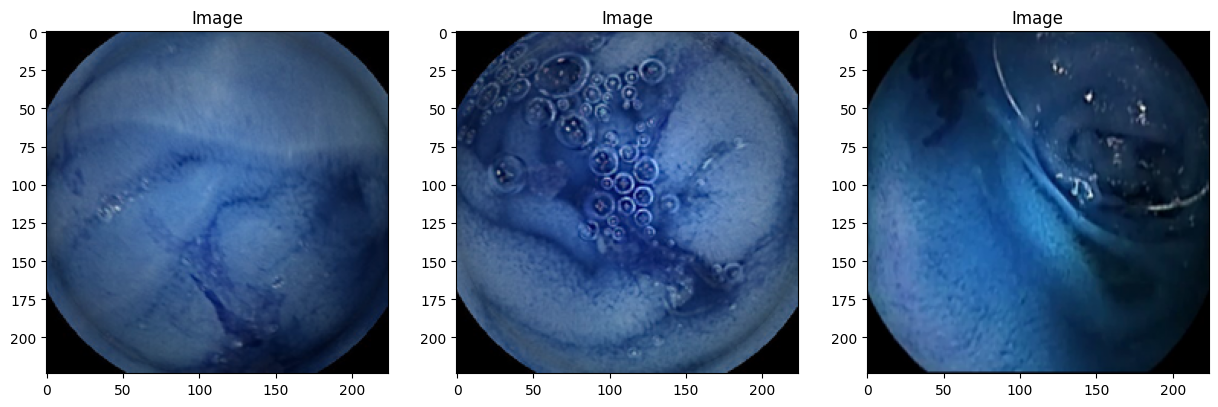

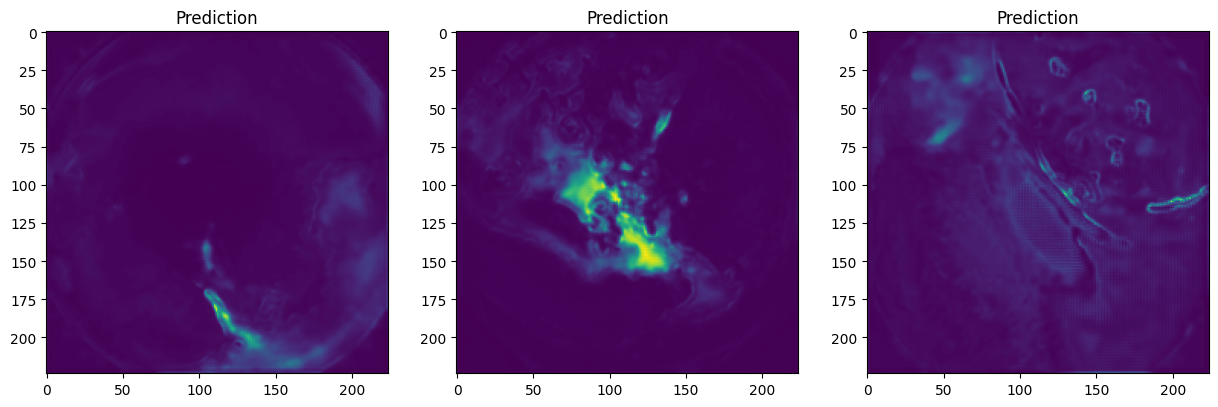

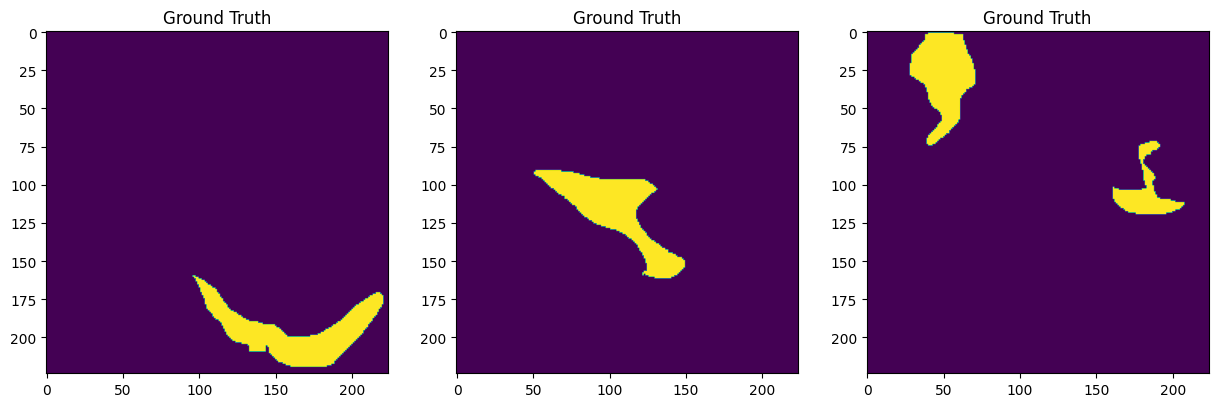

In [32]:
i = 5

# plt.imshow(pred[i])
# plt.show()

# plt.imshow(init_y[i])
# plt.show()

# Plot 3 images in matplotlib side by side horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate([axs[0], axs[1], axs[2]]):
    ax.imshow(init_x[i+1])
    ax.set_title("Image")
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate([axs[0], axs[1], axs[2]]):
    ax.imshow(pred[i+1])
    ax.set_title("Prediction")
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate([axs[0], axs[1], axs[2]]):
    ax.imshow(init_y[i+1])
    ax.set_title("Ground Truth")
plt.show()

In [37]:
# Find the maximum value in an array
def max_in_array(my_list):
    return np.amax(my_list)

max_in_array(init_x[0])

1.0